## Library import

In [1]:
!pip install xgboost


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc,mean_absolute_error, mean_squared_error, r2_score
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import warnings
import os
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
import shap


## Loading dataset

In [3]:
warnings.filterwarnings('ignore')
current_dir = os.getcwd()
print(f"Working directory : {current_dir}")

# To build a complete path
file_path1 = os.path.join(current_dir, "generation_data.csv")
print(f"Complete path : {file_path1}")
file_path2 = os.path.join(current_dir, "weather_data.csv")
print(f"Complete path : {file_path2}")
# Loading data
df_generation = pd.read_csv(f"{file_path1}")
df_weather = pd.read_csv(f"{file_path2}")

Working directory : C:\Users\gfred\Downloads\projet ML
Complete path : C:\Users\gfred\Downloads\projet ML\generation_data.csv
Complete path : C:\Users\gfred\Downloads\projet ML\weather_data.csv


## Exploratory Analysis

### 1. Data structure

In [4]:
print("Generation Data:")
print(f"Shape: {df_generation.shape}")
print(f"Columns: {df_generation.columns.tolist()}")
print("\nWeather Data:")
print(f"Shape: {df_weather.shape}")
print(f"Columns: {df_weather.columns.tolist()}")

# Inspection of first raws
print("\nFIRST ROW - GENERATION")
display(df_generation.head())
print("\nFIRST ROW - WEATHER")
display(df_weather.head())

Generation Data:
Shape: (68778, 7)
Columns: ['DATE_TIME', 'PLANT_ID', 'SOURCE_KEY', 'DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD']

Weather Data:
Shape: (3182, 6)
Columns: ['DATE_TIME', 'PLANT_ID', 'SOURCE_KEY', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']

FIRST ROW - GENERATION


,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,15-05-2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
1,15-05-2020 00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2,15-05-2020 00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
3,15-05-2020 00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
4,15-05-2020 00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0



FIRST ROW - WEATHER


,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0
2,2020-05-15 00:30:00,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0
3,2020-05-15 00:45:00,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0
4,2020-05-15 01:00:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0


### 2. Data Cleaning and Merging

In [5]:
# Convert to datetime 
df_weather['DATE_TIME'] = pd.to_datetime(df_weather['DATE_TIME'])

# Reformat without seconds
df_weather['DATE_TIME'] = df_weather['DATE_TIME'].dt.strftime('%Y-%m-%d %H:%M')

# Verification
display(df_weather.head())

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,2020-05-15 00:15,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0
2,2020-05-15 00:30,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0
3,2020-05-15 00:45,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0
4,2020-05-15 01:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0


In [6]:
# Reconvert DATE_TIME columns to datetime in both DataFrames
df_generation['DATE_TIME'] = pd.to_datetime(df_generation['DATE_TIME'], errors='coerce')
df_weather['DATE_TIME'] = pd.to_datetime(df_weather['DATE_TIME'], errors='coerce')

# Fusion
df_merged = pd.merge(
    df_generation,
    df_weather,
    on=['DATE_TIME', 'PLANT_ID'],
    how='inner'
)
print(f"Shape after merge: {df_merged.shape}")

# Checking for missing values
print("\nMISSING VALUES")
missing_data = df_merged.isnull().sum()
print(missing_data[missing_data > 0])

print("\nDF_MERGED :")
display(df_merged)

Shape after merge: (68774, 11)

MISSING VALUES
Series([], dtype: int64)

DF_MERGED :


,DATE_TIME,PLANT_ID,SOURCE_KEY_x,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,SOURCE_KEY_y,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.000,6259559.0,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,2020-05-15 00:00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.000,6183645.0,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
2,2020-05-15 00:00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.000,6987759.0,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
3,2020-05-15 00:00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.000,7602960.0,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
4,2020-05-15 00:00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.000,7158964.0,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
...,...,...,...,...,...,...,...,...,...,...,...
68769,2020-06-17 23:45:00,4135001,uHbuxQJl8lW7ozc,0.0,0.0,5967.000,7287002.0,HmiyD2TTLFNqkNe,21.909288,20.427972,0.0
68770,2020-06-17 23:45:00,4135001,wCURE6d3bPkepu2,0.0,0.0,5147.625,7028601.0,HmiyD2TTLFNqkNe,21.909288,20.427972,0.0
68771,2020-06-17 23:45:00,4135001,z9Y9gH1T5YWrNuG,0.0,0.0,5819.000,7251204.0,HmiyD2TTLFNqkNe,21.909288,20.427972,0.0
68772,2020-06-17 23:45:00,4135001,zBIq5rxdHJRwDNY,0.0,0.0,5817.000,6583369.0,HmiyD2TTLFNqkNe,21.909288,20.427972,0.0


### 3. Data Cleaning and Merging

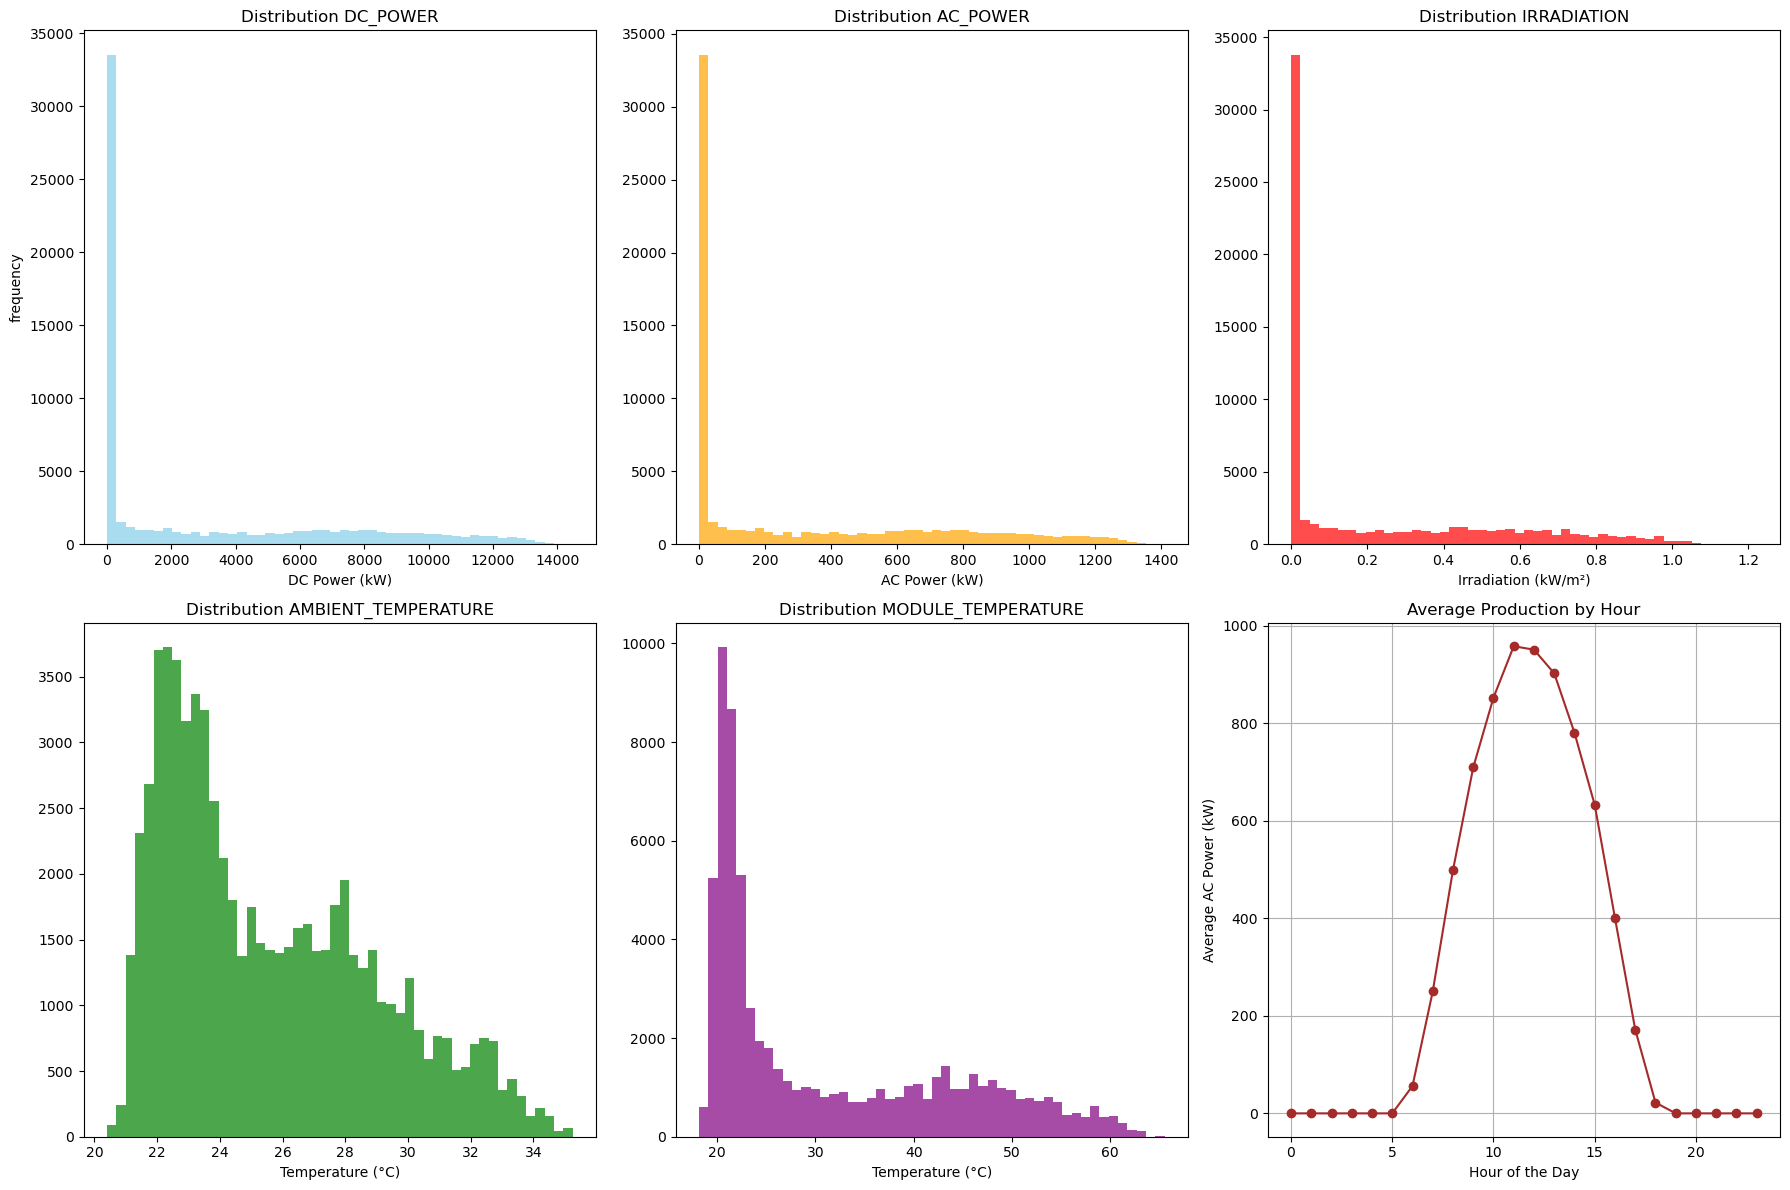

In [7]:
# Graph configuration
plt.style.use('default')
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# DC_POWER Distribution 
axes[0,0].hist(df_merged['DC_POWER'].dropna(), bins=50, alpha=0.7, color='skyblue')
axes[0,0].set_title('Distribution DC_POWER')
axes[0,0].set_xlabel('DC Power (kW)')
axes[0,0].set_ylabel('frequency')

# AC_POWER Distribution 
axes[0,1].hist(df_merged['AC_POWER'].dropna(), bins=50, alpha=0.7, color='orange')
axes[0,1].set_title('Distribution AC_POWER')
axes[0,1].set_xlabel('AC Power (kW)')

# Irradiation distribution
axes[0,2].hist(df_merged['IRRADIATION'].dropna(), bins=50, alpha=0.7, color='red')
axes[0,2].set_title('Distribution IRRADIATION')
axes[0,2].set_xlabel('Irradiation (kW/m²)')

# Ambient temperature
axes[1,0].hist(df_merged['AMBIENT_TEMPERATURE'].dropna(), bins=50, alpha=0.7, color='green')
axes[1,0].set_title('Distribution AMBIENT_TEMPERATURE')
axes[1,0].set_xlabel('Temperature (°C)')

# Module temperature
axes[1,1].hist(df_merged['MODULE_TEMPERATURE'].dropna(), bins=50, alpha=0.7, color='purple')
axes[1,1].set_title('Distribution MODULE_TEMPERATURE')
axes[1,1].set_xlabel('Temperature (°C)')

# Production by hour of the day
df_merged['HOUR'] = df_merged['DATE_TIME'].dt.hour
hourly_production = df_merged.groupby('HOUR')['AC_POWER'].mean()
axes[1,2].plot(hourly_production.index, hourly_production.values, marker='o', color='brown')
axes[1,2].set_title('Average Production by Hour')
axes[1,2].set_xlabel('Hour of the Day')
axes[1,2].set_ylabel('Average AC Power (kW)')
axes[1,2].grid(True)

plt.tight_layout()
plt.show()

### 4. Correlation Matrix

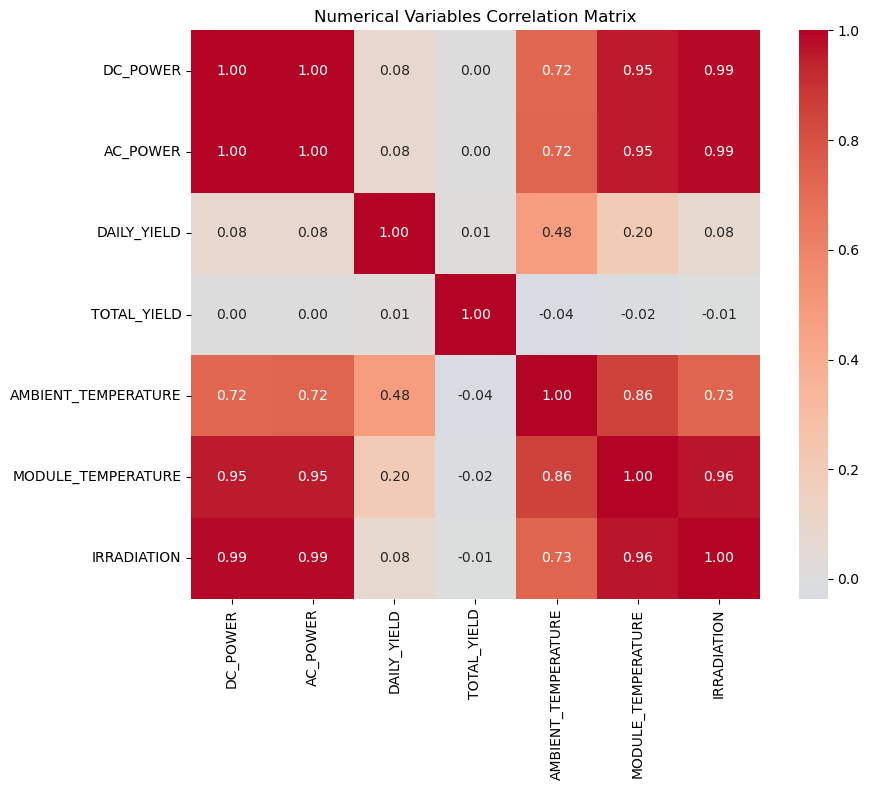

In [8]:
# Calculating correlations
numeric_cols = ['DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD', 
                'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']
correlation_matrix = df_merged[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f')
plt.title('Numerical Variables Correlation Matrix')
plt.tight_layout()
plt.show()

### 5. Imbalance Diagnosis

Classification Problem Definition

In [9]:
print("=== IMBALANCE DIAGNOSIS ===")

#  1. Filter valid data (avoid division by zero)
df_valid = df_merged[df_merged['DC_POWER'] > 0].copy()

#  2. Conversion efficiency calculation
df_valid['CONVERSION_EFFICIENCY'] = df_valid['AC_POWER'] / df_valid['DC_POWER']

#  3. Descriptive statistics for verification
print("\nStatistical summary of conversion efficiency :")
print(df_valid['CONVERSION_EFFICIENCY'].describe())

# 4. Target variable definition: abnormal production
# We consider the worst 10% of efficiencies as abnormal
efficiency_threshold = df_valid['CONVERSION_EFFICIENCY'].quantile(0.1)
df_valid['TARGET'] = (df_valid['CONVERSION_EFFICIENCY'] < efficiency_threshold).astype(int)

# 5. Imbalance analysis
target_distribution = df_valid['TARGET'].value_counts()

# Checking for the presence of both classes
if 0 in target_distribution.index and 1 in target_distribution.index:
    imbalance_ratio = target_distribution[1] / target_distribution[0]

    print("\nTarget variable distribution :")
    print(f"Class 0 (Normal)  : {target_distribution[0]} échantillons")
    print(f"Class 1 (Abnormal) : {target_distribution[1]} échantillons")
    print(f"Imbalance ratio : 1:{1/imbalance_ratio:.1f}")
    print(f"Percentage of anomalies : {target_distribution[1]/len(df_valid)*100:.2f}%")

    #  6. Classification of imbalance level
    if imbalance_ratio > 0.5:
        imbalance_level = "Low"
    elif imbalance_ratio > 0.1:
        imbalance_level = "Moderate"     
    else:
        imbalance_level = "Severe"

    print(f"\nImbalance level : {imbalance_level}")

else:
    print("\n Warning: Only one class detected. Adjust the threshold or check your data.")
    print(target_distribution)


=== IMBALANCE DIAGNOSIS ===

Statistical summary of conversion efficiency :
count    36823.000000
mean         0.097719
std          0.000458
min          0.095552
25%          0.097579
50%          0.097845
75%          0.098014
max          0.106592
Name: CONVERSION_EFFICIENCY, dtype: float64

Target variable distribution :
Class 0 (Normal)  : 33140 échantillons
Class 1 (Abnormal) : 3683 échantillons
Imbalance ratio : 1:9.0
Percentage of anomalies : 10.00%

Imbalance level : Moderate


### 6. Visualization of Imbalance

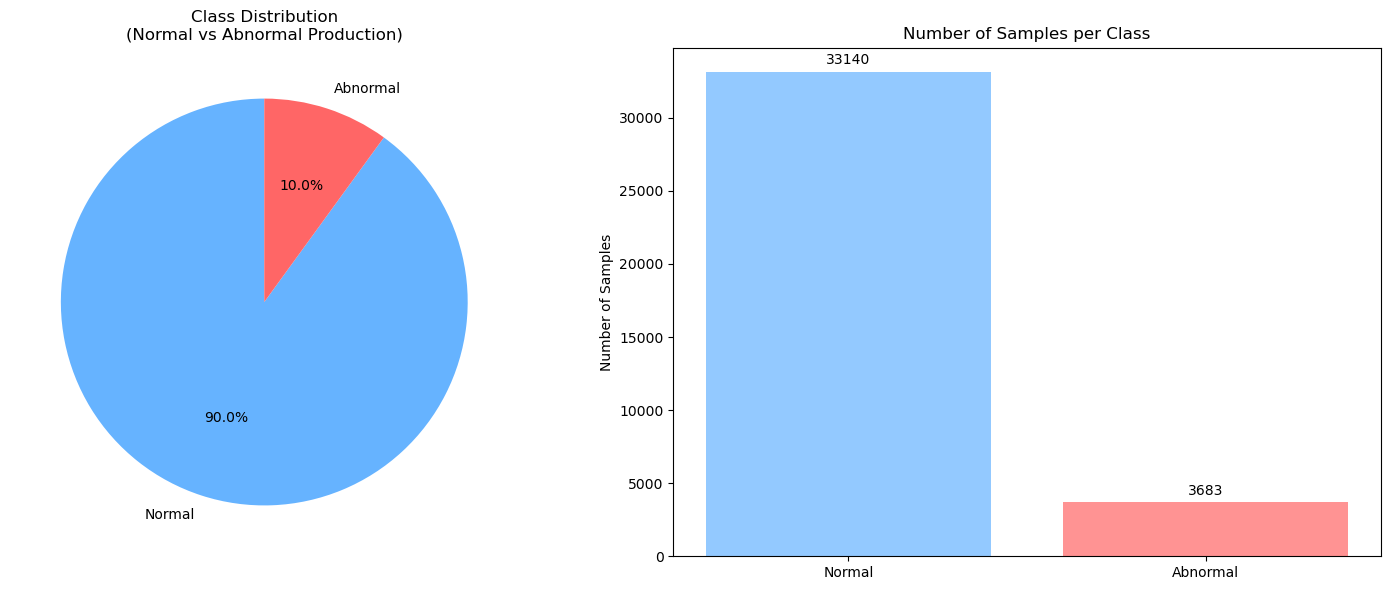

In [10]:
# Class distribution chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Pie chart
colors = ['#66b3ff', '#ff6666']
ax1.pie(target_distribution.values, labels=['Normal', 'Abnormal'], 
        autopct='%1.1f%%', colors=colors, startangle=90)
ax1.set_title('Class Distribution\n(Normal vs Abnormal Production)')

# Bar plot
ax2.bar(['Normal', 'Abnormal'], target_distribution.values, 
        color=colors, alpha=0.7)
ax2.set_title('Number of Samples per Class')
ax2.set_ylabel('Number of Samples')
for i, v in enumerate(target_distribution.values):
    ax2.text(i, v + max(target_distribution.values)*0.01, str(v), 
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

### 7. Data Preprocessing

Feature Engineering and selection

In [11]:
print("=== DATA PREPROCESSING ===")

# Feature engineering sur df_valid (pas df_merged)
df_valid['HOUR'] = df_valid['DATE_TIME'].dt.hour
df_valid['DAY_OF_WEEK'] = df_valid['DATE_TIME'].dt.dayofweek
df_valid['MONTH'] = df_valid['DATE_TIME'].dt.month
df_valid['IS_DAYLIGHT'] = ((df_valid['HOUR'] >= 6) & (df_valid['HOUR'] <= 18)).astype(int)
df_valid['TEMP_DIFF'] = df_valid['MODULE_TEMPERATURE'] - df_valid['AMBIENT_TEMPERATURE']

# Feature selection
features = ['DC_POWER', 'AC_POWER', 'AMBIENT_TEMPERATURE', 
            'MODULE_TEMPERATURE', 'IRRADIATION', 'HOUR', 
            'IS_DAYLIGHT', 'TEMP_DIFF', 'DAILY_YIELD']

X = df_valid[features]
y = df_valid['TARGET']

# Handling missing values
X = X.fillna(X.median())

print(f"Final dataset: {X.shape}")
print(f"Features used: {features}")


=== DATA PREPROCESSING ===
Final dataset: (36823, 9)
Features used: ['DC_POWER', 'AC_POWER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 'HOUR', 'IS_DAYLIGHT', 'TEMP_DIFF', 'DAILY_YIELD']


Data Preparation for the Model


=== PCA ANALYSIS ===
Number of components required for 95% variance: 2


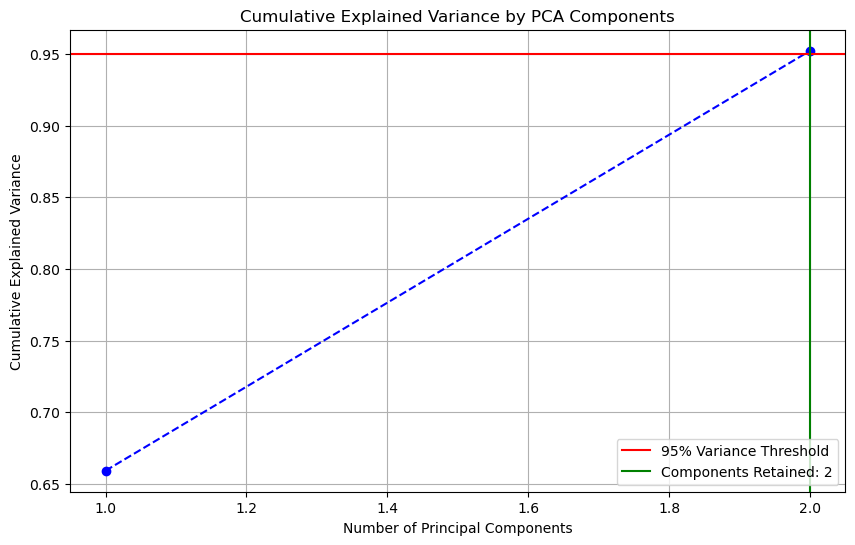


Variance explained by the 2 components: 0.9522

Data split:
Train set (PCA): (25776, 2), Original features: 9
Test set (PCA): (11047, 2)


In [12]:
# Data split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
pca = PCA(n_components=0.95)  
# PCA fit and transform
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# === ADDING PCA ANALYSIS AND VISUALIZATION ===
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)
n_components = pca.n_components_

print("\n=== PCA ANALYSIS ===")
print(f"Number of components required for 95% variance: {n_components}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='blue')
plt.axhline(y=0.95, color='r', linestyle='-', label='95% Variance Threshold')
plt.axvline(x=n_components, color='g', linestyle='-', label=f'Components Retained: {n_components}')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"\nVariance explained by the {n_components} components: {cumulative_variance[-1]:.4f}")
print(f"\nData split:")
print(f"Train set (PCA): {X_train_pca.shape}, Original features: {X_train_scaled.shape[1]}")
print(f"Test set (PCA): {X_test_pca.shape}")

### 8. Baseline Models Without Imbalance Treatment

Implementation of Baseline Models

In [13]:
print("=== BASELINE MODELS (WITHOUT IMBALANCE TREATMENT) ===")

models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

baseline_results = {}

for name, model in models.items():
    print(f"\n--- {name} ---")
    
    # Training
    model.fit(X_train_pca, y_train)
    
    # Predictions
    y_pred = model.predict(X_test_pca)
    y_pred_proba = model.predict_proba(X_test_pca)[:, 1]
    
    # Metrics
    accuracy = model.score(X_test_pca, y_test)
    roc_auc = roc_auc_score(y_test, y_pred)
    MAE = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    R2 = r2_score(y_test, y_pred)

    
    # Classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    precision = report['1']['precision']
    recall = report['1']['recall']
    f1 = report['1']['f1-score']
    
    # Storing results
    baseline_results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'model': model,
        'MAE' : MAE,
        'R2':R2
    }
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"MAE: {MAE:.4f}")
    print(f"R2: {R2:.4f}")

=== BASELINE MODELS (WITHOUT IMBALANCE TREATMENT) ===

--- Logistic Regression ---
Accuracy: 0.9786
Precision: 0.8876
Recall: 0.9005
F1-Score: 0.8940
ROC-AUC: 0.9439
MAE: 0.0214
R2: 0.7627

--- Random Forest ---
Accuracy: 0.9955
Precision: 0.9748
Recall: 0.9801
F1-Score: 0.9774
ROC-AUC: 0.9886
MAE: 0.0045
R2: 0.9497

--- SVM ---
Accuracy: 0.9842
Precision: 0.9175
Recall: 0.9258
F1-Score: 0.9216
ROC-AUC: 0.9583
MAE: 0.0158
R2: 0.8250


Visualization of Baseline Results

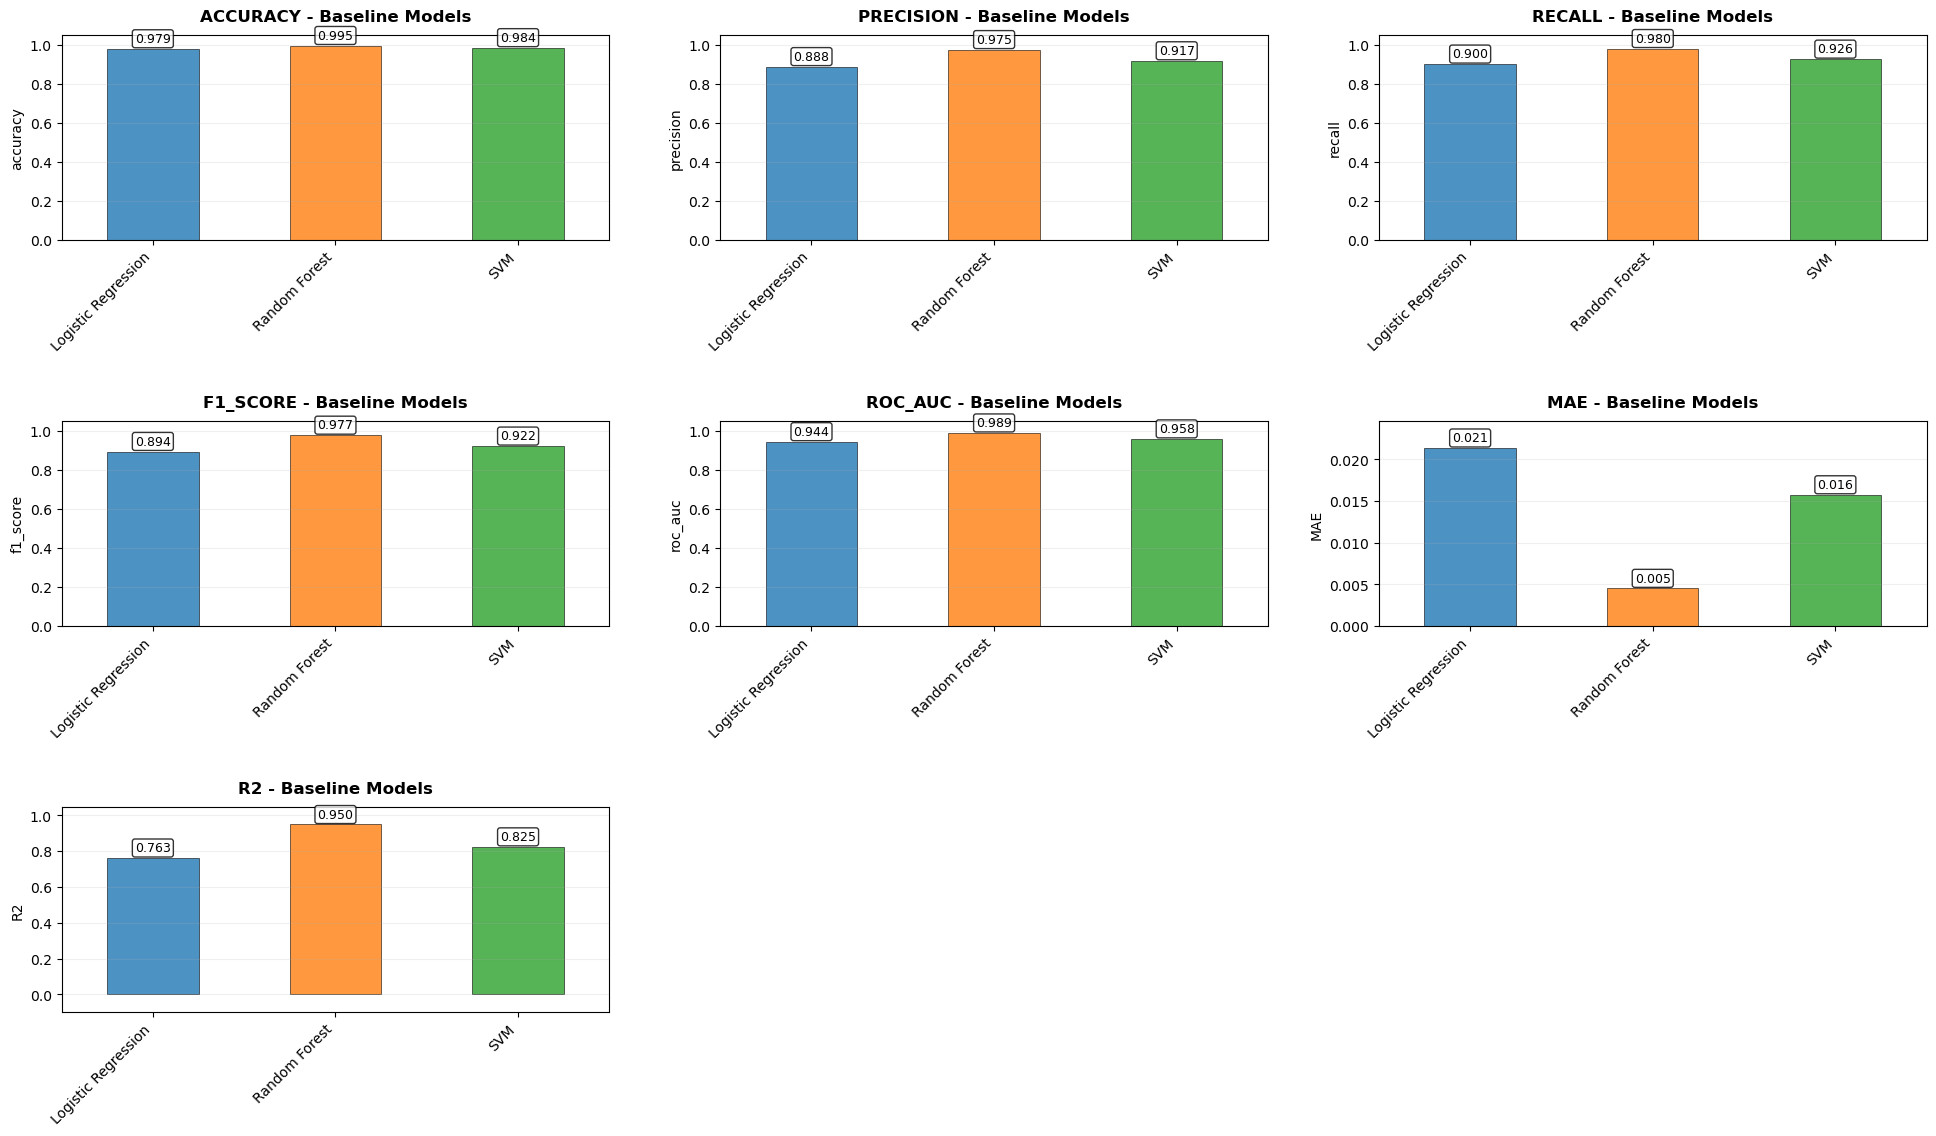

In [14]:
# Baseline Results DataFrame
baseline_df = pd.DataFrame(baseline_results).T
baseline_metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'MAE', 'R2']

plt.figure(figsize=(20, 12))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

for i, metric in enumerate(baseline_metrics, 1):
    plt.subplot(3, 3, i)
    bars = baseline_df[metric].plot(kind='bar', color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
    plt.title(f'{metric.upper()} - Baseline Models', fontsize=12, fontweight='bold', pad=10)
    plt.ylabel(metric, fontsize=10)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.2)
    
    # Ajust y limits 
    if metric in ['MAE']:
        plt.ylim(0, max(baseline_df[metric]) * 1.15)
    elif metric in ['R2']:
        plt.ylim(min(-0.1, baseline_df[metric].min() * 1.1), max(1.0, baseline_df[metric].max() * 1.1))
    else:
        plt.ylim(0, 1.05)
    
    # Values on bars 
    for j, v in enumerate(baseline_df[metric]):
        y_pos = v + (max(baseline_df[metric]) * 0.02)
        plt.text(j, y_pos, f'{v:.3f}', ha='center', va='bottom', fontsize=9, 
                bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8))

plt.tight_layout(pad=3.0)
plt.show()

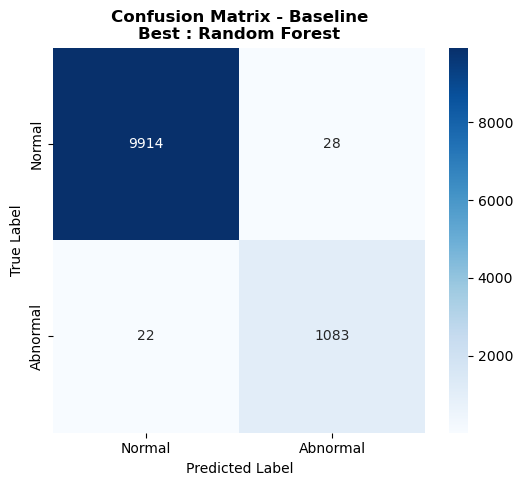

In [15]:
# Trouver le meilleur modèle de cette étape
best_name = max(baseline_results, key=lambda x: baseline_results[x]['f1_score'])
best_model = baseline_results[best_name]['model']

# Prédictions
y_pred = best_model.predict(X_test_pca)
cm = confusion_matrix(y_test, y_pred)

# Affichage
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Abnormal'],
            yticklabels=['Normal', 'Abnormal'])
plt.title(f"Confusion Matrix - Baseline\nBest : {best_name}", fontsize=12, weight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### 9. Resampling Techniques

Application of Imbalanced Data Techniques

In [16]:
print("=== RESAMPLING TECHNIQUES ===")

# Definition of Resampling Techniques
resampling_techniques = {
    'Original': None,
    'Random Oversampling': RandomOverSampler(random_state=42),
    'SMOTE': SMOTE(random_state=42),
    'Random Undersampling': RandomUnderSampler(random_state=42)
}

# Baseline Model (Random Forest)
base_model = RandomForestClassifier(random_state=42)

resampling_results = {}

for technique_name, resampler in resampling_techniques.items():
    model = RandomForestClassifier(random_state=42)

    if resampler is None:
        # Original data
        X_resampled, y_resampled = X_train_pca, y_train
    else:
        # Application of resampling
        X_resampled, y_resampled = resampler.fit_resample(X_train_pca, y_train)
    
    # Model training
    model = base_model
    model.fit(X_resampled, y_resampled)
    
    # Prediction and evaluation
    y_pred = model.predict(X_test_pca)
    y_pred_proba = model.predict_proba(X_test_pca)[:, 1]
    
    # Metrics
    accuracy = model.score(X_test_pca, y_test)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    report = classification_report(y_test, y_pred, output_dict=True)
    MAE = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    R2 = r2_score(y_test, y_pred)
    
    resampling_results[technique_name] = {
        'accuracy': accuracy,
        'precision': report['1']['precision'],
        'recall': report['1']['recall'],
        'f1_score': report['1']['f1-score'],
        'roc_auc': roc_auc,
        'MAE':MAE,
        'R2':R2,
        'train_distribution': np.bincount(y_resampled)
    }
resampling_df = pd.DataFrame(resampling_results).T
display(resampling_df[['precision', 'recall', 'f1_score', 'roc_auc','MAE','R2']])


=== RESAMPLING TECHNIQUES ===


,precision,recall,f1_score,roc_auc,MAE,R2
Original,0.974797,0.98009,0.977437,0.998851,0.004526,0.949722
Random Oversampling,0.968861,0.98552,0.97712,0.998649,0.004617,0.948716
SMOTE,0.96319,0.99457,0.978629,0.998615,0.004345,0.951733
Random Undersampling,0.907895,0.999095,0.951314,0.998219,0.010229,0.886372


Comparative Visualization of Techniques

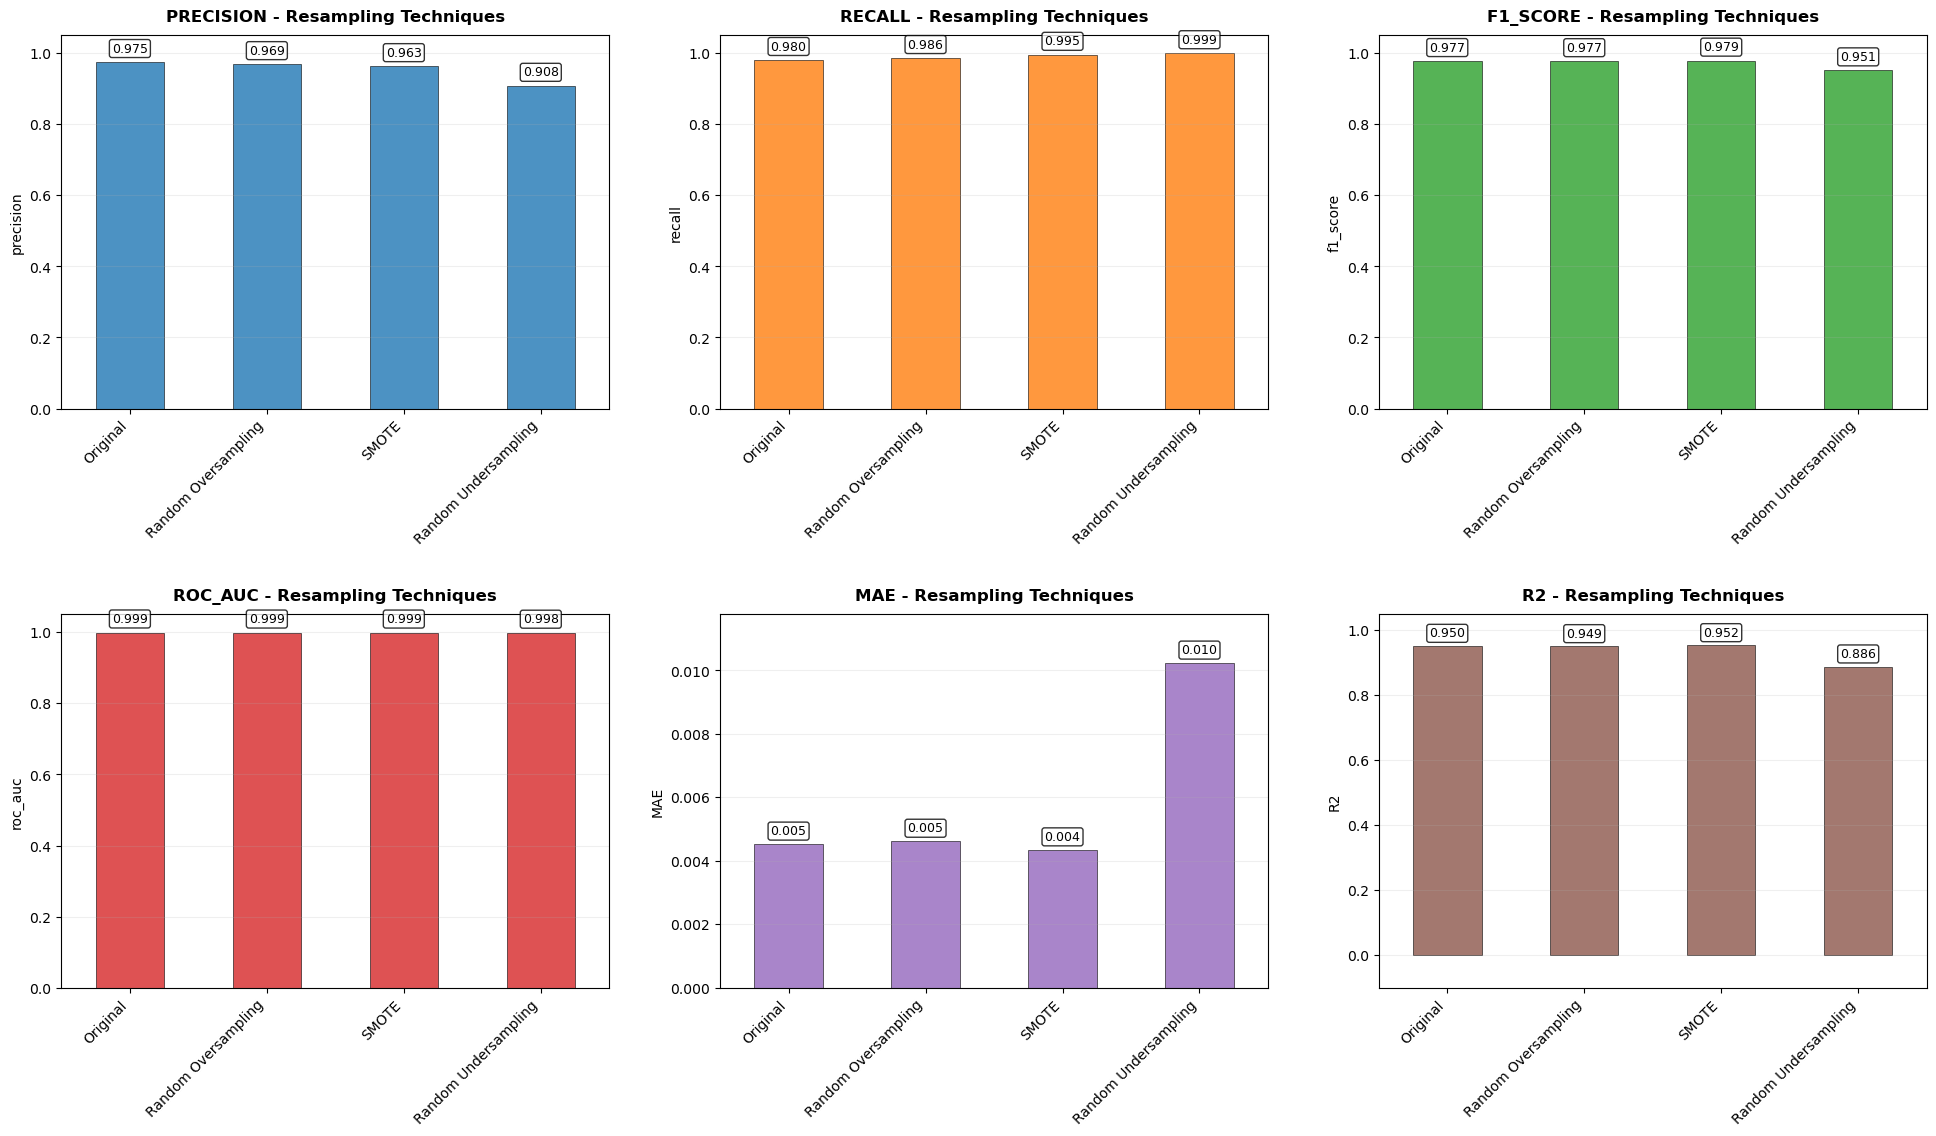

In [17]:
# Comparison of Resampling Techniques
resampling_df = pd.DataFrame(resampling_results).T
resampling_metrics = ['precision', 'recall', 'f1_score', 'roc_auc', 'MAE', 'R2']

plt.figure(figsize=(20, 12))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

for i, metric in enumerate(resampling_metrics, 1):
    plt.subplot(2, 3, i)
    bars = resampling_df[metric].plot(kind='bar', color=colors[i-1], alpha=0.8, edgecolor='black', linewidth=0.5)
    plt.title(f'{metric.upper()} - Resampling Techniques', fontsize=12, fontweight='bold', pad=10)
    plt.ylabel(metric, fontsize=10)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.2)
    
    # Ajust y limits 
    if metric in ['MAE']:
        plt.ylim(0, max(resampling_df[metric]) * 1.15)
    elif metric in ['R2']:
        plt.ylim(min(-0.1, resampling_df[metric].min() * 1.1), max(1.0, resampling_df[metric].max() * 1.1))
    else:
        plt.ylim(0, 1.05)
    
    # Values on bars 
    for j, v in enumerate(resampling_df[metric]):
        y_pos = v + (max(resampling_df[metric]) * 0.02)
        plt.text(j, y_pos, f'{v:.3f}', ha='center', va='bottom', fontsize=9, 
                bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8))

plt.tight_layout(pad=3.0)
plt.show()

### 10. Advanced Models with Imbalance Handling

Model + Advanced Techniques Combination

In [18]:
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

advanced_models = {
    'RF + class_weight': RandomForestClassifier(
        class_weight='balanced',
        random_state=42
    ),
    'RF + SMOTE': Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42))
    ]),
    'SVM + class_weight': SVC(
        class_weight='balanced',
        probability=True,
        random_state=42
    ),
    'XGBoost + scale_pos_weight': XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        random_state=42,
        use_label_encoder=False
    ),
    'XGBoost + SMOTE': Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('xgb', XGBClassifier(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            eval_metric='logloss',
            random_state=42,
            use_label_encoder=False
        ))
    ])
}


#  Training and Evaluation

advanced_results = {}

for model_name, model in advanced_models.items():
    # Training
    model.fit(X_train_pca, y_train)
    
    # Predictions
    y_pred = model.predict(X_test_pca)
    y_pred_proba = model.predict_proba(X_test_pca)[:, 1]
    
    # Evaluations
    report = classification_report(y_test, y_pred, output_dict=True)
    accuracy = model.score(X_test_pca, y_test)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    MAE = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    R2 = r2_score(y_test, y_pred)
    
    
    # Precision-Recall curve
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall_curve, precision_curve)
    
    # Saving the results
    advanced_results[model_name] = {
        'accuracy': accuracy,
        'precision': report['1']['precision'],
        'recall': report['1']['recall'],
        'f1_score': report['1']['f1-score'],
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'model': model,
        'MAE':MAE,
        'R2':R2
    }
import pandas as pd

results_df = pd.DataFrame(advanced_results).T[
    ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'pr_auc','MAE','R2']
]
print("\n=== COMPARATIVE SUMMARY ===")
display(results_df.sort_values('roc_auc', ascending=False))


=== COMPARATIVE SUMMARY ===


,accuracy,precision,recall,f1_score,roc_auc,pr_auc,MAE,R2
RF + class_weight,0.995655,0.974843,0.9819,0.978359,0.999296,0.991683,0.004345,0.951733
RF + SMOTE,0.995655,0.96319,0.99457,0.978629,0.998615,0.990401,0.004345,0.951733
XGBoost + scale_pos_weight,0.973296,0.790948,0.99638,0.881858,0.998234,0.98142,0.026704,0.70336
XGBoost + SMOTE,0.977732,0.823175,0.990045,0.898932,0.998154,0.981968,0.022268,0.752632
SVM + class_weight,0.971938,0.780919,1.0,0.876984,0.997678,0.973851,0.028062,0.688276


Stratified Cross-Validation

In [19]:
# Selection of the best model based on F1-score
best_model_name = max(advanced_results.items(), key=lambda x: x[1]['f1_score'])[0]
best_model = advanced_results[best_model_name]['model']

print(f"Best model based on F1-score : {best_model_name}")

# 5-fold stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Calculating F1 scores for each fold
cv_scores = cross_val_score(best_model, X_train_pca, y_train, 
                            cv=cv, scoring='f1')

print(f"\nCross-validation for {best_model_name}:")
print(f"Scores F1 par fold: {cv_scores}")
print(f"Average F1: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Best model based on F1-score : RF + SMOTE

Cross-validation for RF + SMOTE:
Scores F1 par fold: [0.96975425 0.97115385 0.97137405 0.96946565 0.97142857]
Average F1: 0.9706 (+/- 0.0017)


### 11. Hyperparameter Optimization

In [20]:
# Cell In[20] (CORRECTED CODE)

from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline # Import Pipeline from imblearn

print("=== HYPERPARAMETER OPTIMIZATION (XGBoost + SMOTE) ===")

# --- CORRECTION ---
# Re-define the correct pipeline for XGBoost + SMOTE to ensure 
# the step name is 'xgb' as used in the grid search parameters.
pipeline_smote_xgb = Pipeline([
    ('smote', SMOTE(random_state=42)),
    # Ensure this step is named 'xgb'
    ('xgb', XGBClassifier(
        n_estimators=100, # Initial small estimator count
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    ))
])


# Define the hyperparameter grid for XGBoost
# The prefix 'xgb__' correctly targets the 'xgb' step in the pipeline.
param_grid = {
    'xgb__max_depth': [3, 5, 7],
    'xgb__n_estimators': [100, 200],
    'xgb__learning_rate': [0.05, 0.1],
    'xgb__subsample': [0.8, 1.0]
}

# Use GridSearchCV with StratifiedKFold
# We use 'f1' as the primary metric due to class imbalance
grid_search = GridSearchCV(
    estimator=pipeline_smote_xgb,
    param_grid=param_grid,
    scoring='f1', 
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42), 
    verbose=1, 
    n_jobs=-1
)

# Train the Grid Search
# Note: This step might be time-consuming.
grid_search.fit(X_train_pca, y_train) 

# Retrieve the best model and parameters
best_xgb_smote_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("\nBest hyperparameters found:")
print(best_params)

# ... (Rest of the evaluation code follows)

# Evaluation of the optimized model
y_pred_tuned = best_xgb_smote_model.predict(X_test_pca)
y_pred_proba_tuned = best_xgb_smote_model.predict_proba(X_test_pca)[:, 1]
report_tuned = classification_report(y_test, y_pred_tuned, output_dict=True)
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba_tuned)
pr_auc_tuned = auc(recall_curve, precision_curve)

# Update results dictionary
# Note: You should check if you need to calculate MAE and R2 for the optimized model 
# (which are typically regression metrics but used here for comparison).
advanced_results['XGBoost + SMOTE (Optimized)'] = {
    'accuracy': best_xgb_smote_model.score(X_test_pca, y_test),
    'precision': report_tuned['1']['precision'],
    'recall': report_tuned['1']['recall'],
    'f1_score': report_tuned['1']['f1-score'],
    'roc_auc': roc_auc_score(y_test, y_pred_proba_tuned),
    'pr_auc': pr_auc_tuned,
    'MAE': mean_absolute_error(y_test, y_pred_tuned),
    'R2': r2_score(y_test, y_pred_tuned),
    'model': best_xgb_smote_model
}

print("\n--- OPTIMIZED MODEL RESULTS ---")
print(f"F1-Score: {advanced_results['XGBoost + SMOTE (Optimized)']['f1_score']:.4f}")

# Re-run the final ranking and visualization steps after this cell.

=== HYPERPARAMETER OPTIMIZATION (XGBoost + SMOTE) ===
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best hyperparameters found:
{'xgb__learning_rate': 0.1, 'xgb__max_depth': 7, 'xgb__n_estimators': 200, 'xgb__subsample': 0.8}

--- OPTIMIZED MODEL RESULTS ---
F1-Score: 0.9748


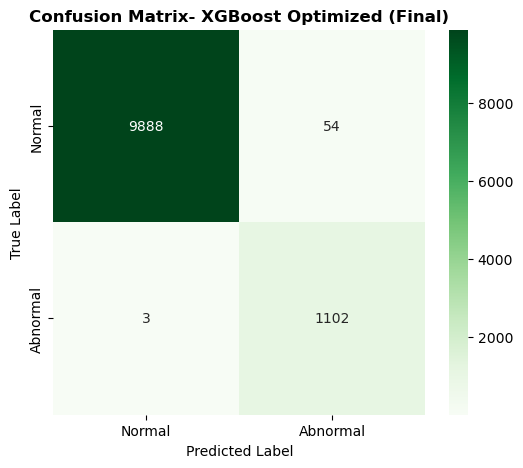

In [21]:
# Matrice pour le modèle optimisé final
y_pred_opt = best_xgb_smote_model.predict(X_test_pca)
cm_opt = confusion_matrix(y_test, y_pred_opt)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Normal', 'Abnormal'],
            yticklabels=['Normal', 'Abnormal'])
plt.title("Confusion Matrix- XGBoost Optimized (Final)", fontsize=12, weight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### 12. Comparative Evaluation


 Model Ranking (sorted by f1_score) :

                                 accuracy precision    recall  f1_score  \
Resampling SMOTE                 0.995655   0.96319   0.99457  0.978629   
RF + SMOTE                       0.995655   0.96319   0.99457  0.978629   
RF + class_weight                0.995655  0.974843    0.9819  0.978359   
Baseline Random Forest           0.995474  0.974797   0.98009  0.977437   
Resampling Original              0.995474  0.974797   0.98009  0.977437   
Resampling Random Oversampling   0.995383  0.968861   0.98552   0.97712   
XGBoost + SMOTE (Optimized)       0.99484  0.953287  0.997285   0.97479   
Resampling Random Undersampling  0.989771  0.907895  0.999095  0.951314   
Baseline SVM                     0.984249  0.917489  0.925792  0.921622   
XGBoost + SMOTE                  0.977732  0.823175  0.990045  0.898932   
Baseline Logistic Regression     0.978637    0.8876  0.900452   0.89398   
XGBoost + scale_pos_weight       0.973296  0.790948   0.9963

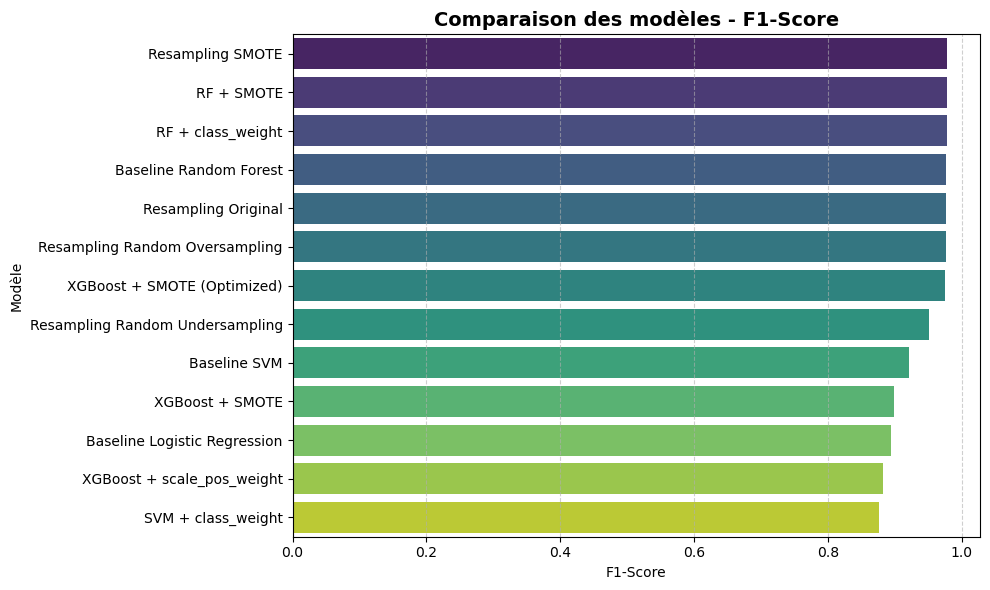

<Figure size 1000x600 with 0 Axes>

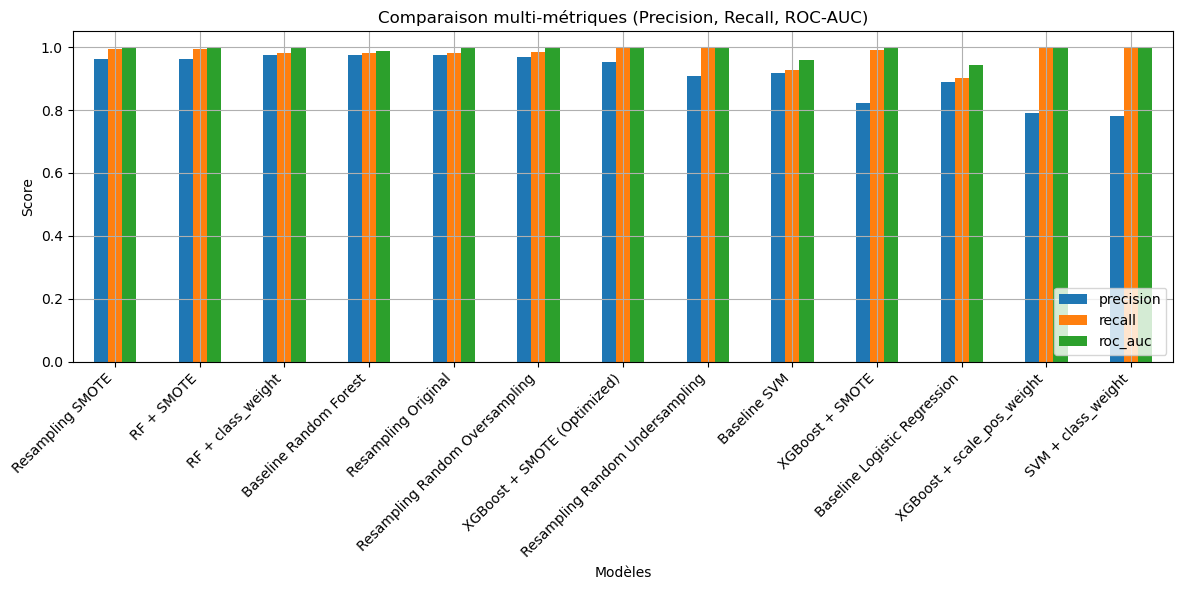

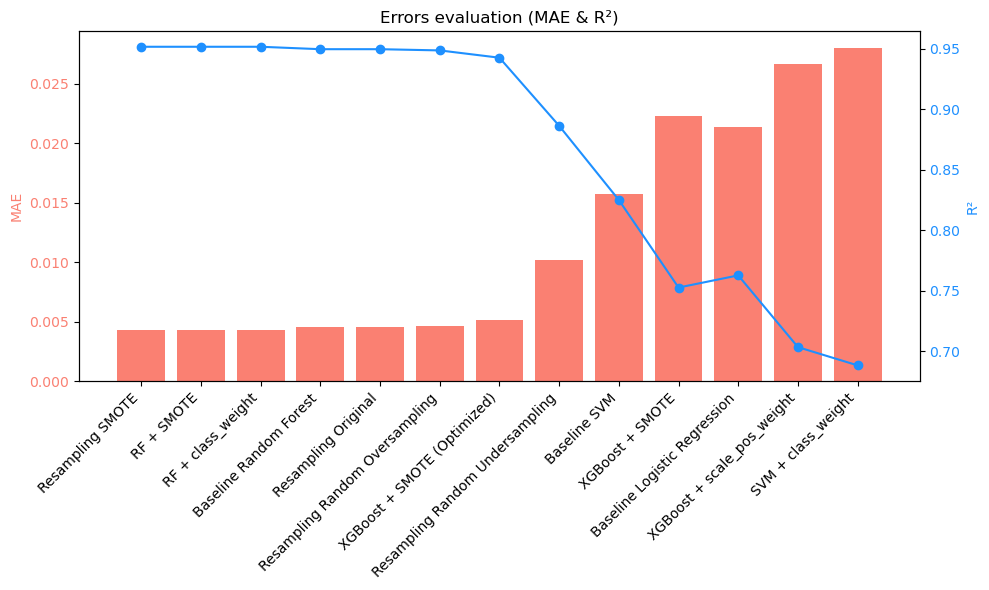

In [22]:
# Cell In[21] (Modification of the original In[19])
# This re-runs the comparison with the new optimized model included.

all_results = {}
if 'baseline_results' in locals():
    all_results.update({f"Baseline {k}": v for k, v in baseline_results.items() if isinstance(v, dict)})
if 'resampling_results' in locals():
    all_results.update({f"Resampling {k}": v for k, v in resampling_results.items() if isinstance(v, dict)})
if 'advanced_results' in locals():
    # Only include models that have the expected metrics (F1-score, etc.)
    all_results.update({k: v for k, v in advanced_results.items() if 'f1_score' in v})


# Creation of the comparative Dataframe
comparison_df = pd.DataFrame(all_results).T

metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'MAE', 'R2']

# We keep only those that exist
comparison_df = comparison_df[[m for m in metrics if m in comparison_df.columns]]

# Sort by F1-score if available, otherwise by R2
sort_metric = 'f1_score' if 'f1_score' in comparison_df.columns else 'R2'
comparison_df = comparison_df.sort_values(sort_metric, ascending=False)


print(f"\n Model Ranking (sorted by {sort_metric}) :\n")
print(comparison_df.round(4))
print(f"\nBest overall model :", comparison_df.index[0])

# =====================
# Comparative visualisation (F1-score)
# =====================
if 'f1_score' in comparison_df.columns:
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=comparison_df.reset_index(),
        x='f1_score', y='index', palette='viridis'
    )
    plt.title('Comparaison des modèles - F1-Score', fontsize=14, weight='bold')
    plt.xlabel('F1-Score')
    plt.ylabel('Modèle')
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# =====================
# Multi-metric visualization (Precision, Recall, ROC-AUC)
# =====================
multi_metrics = [m for m in ['precision', 'recall', 'roc_auc'] if m in comparison_df.columns]
if len(multi_metrics) > 0:
    plt.figure(figsize=(10, 6))
    comparison_df[multi_metrics].plot(kind='bar', figsize=(12, 6), grid=True)
    plt.title('Comparaison multi-métriques (Precision, Recall, ROC-AUC)')
    plt.ylabel('Score')
    plt.xlabel('Modèles')
    plt.xticks(rotation=45, ha='right')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

# =====================
# Regression metrics visualizationn (MAE and R²)
# =====================
if 'MAE' in comparison_df.columns and 'R2' in comparison_df.columns:
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.bar(comparison_df.index, comparison_df['MAE'], color='salmon', label='MAE')
    ax1.set_ylabel('MAE', color='salmon')
    ax1.tick_params(axis='y', labelcolor='salmon')
    ax1.set_xticklabels(comparison_df.index, rotation=45, ha='right')

    ax2 = ax1.twinx()
    ax2.plot(comparison_df.index, comparison_df['R2'], color='dodgerblue', marker='o', label='R²')
    ax2.set_ylabel('R²', color='dodgerblue')
    ax2.tick_params(axis='y', labelcolor='dodgerblue')

    plt.title('Errors evaluation (MAE & R²)')
    fig.tight_layout()
    plt.show()

# (Optional) Export of results
# comparison_df.to_excel("comparative_model_results.xlsx", index=True)


=== ROC CURVE COMPARISON ===






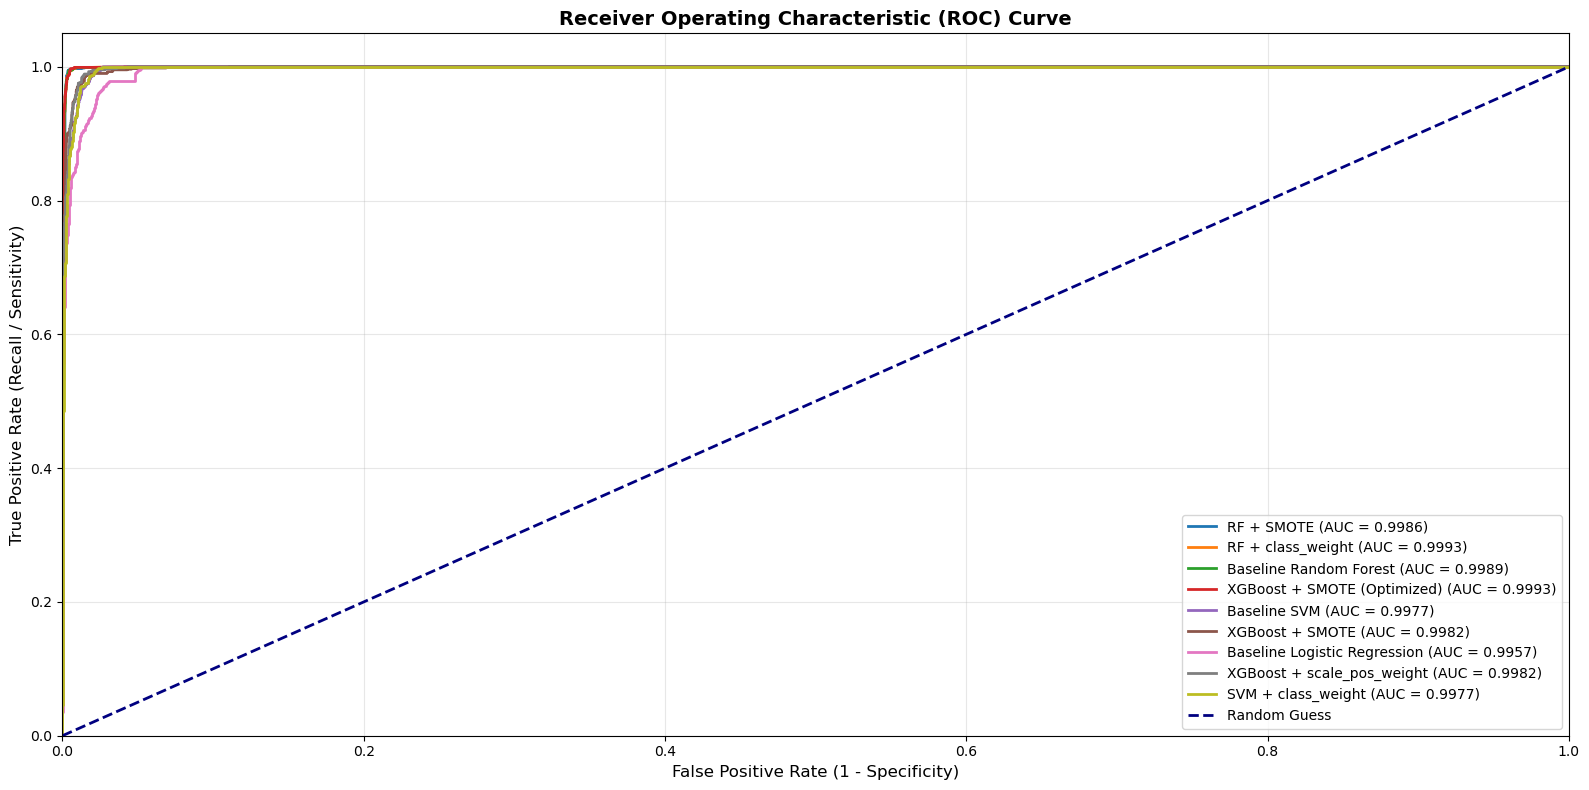

In [23]:
from sklearn.metrics import roc_curve, auc

print("\n=== ROC CURVE COMPARISON ===")

plt.figure(figsize=(16, 8))

# Iterate through the models in your comparison dataframe
# We use the dataframe index to ensure we plot the same models we just ranked
for model_name in comparison_df.index:
    try:
        # 1. Retrieve the model object from the dictionary
        if model_name in all_results:
            model = all_results[model_name]['model']
        else:
            continue

        # 2. Predict probabilities
        # IMPORTANT: We use the same X_test_pca used for evaluation
        if hasattr(model, "predict_proba"):
            # Get probability for the Positive class (1)
            y_scores = model.predict_proba(X_test_pca)[:, 1]
            
            # 3. Compute ROC curve metrics
            fpr, tpr, thresholds = roc_curve(y_test, y_scores)
            roc_auc = auc(fpr, tpr)

            # 4. Plot the curve
            plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.4f})')
            
    except Exception as e:
        print(f"")

# Plot the "Random Guess" line (diagonal)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

# Graph styling
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Recall / Sensitivity)', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, weight='bold')
plt.legend(loc="lower right", frameon=True, fontsize=10)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 13. Business Insights


=== ROOT CAUSE ANALYSIS ===


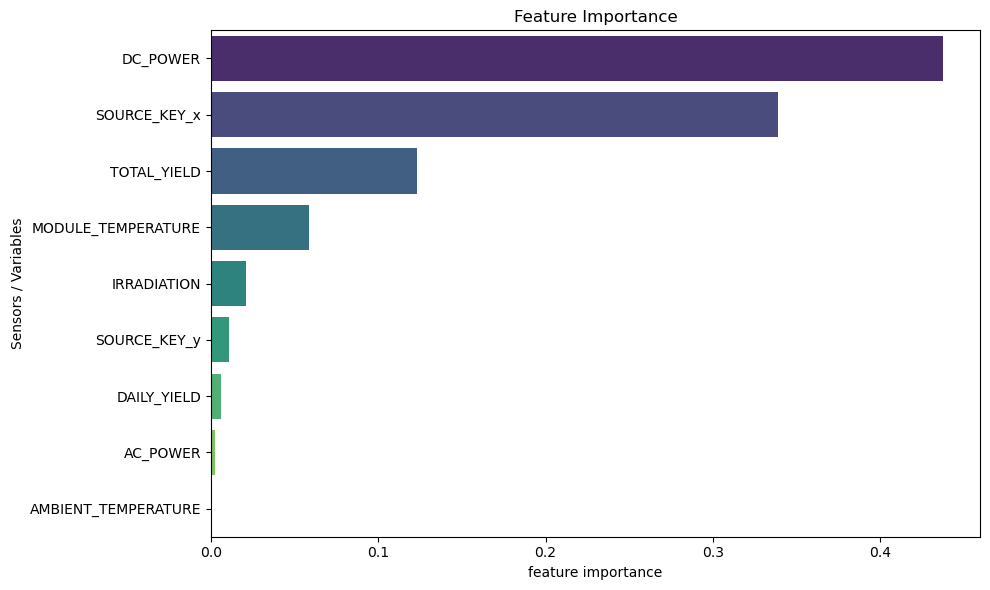

In [24]:
print("\n=== ROOT CAUSE ANALYSIS ===")
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. We re-train a simple Random Forest on the SCALED data (X_train_scaled)
# (This model is just for understanding the data, not for prediction)
rf_explainer = RandomForestClassifier(n_estimators=100, random_state=42)
rf_explainer.fit(X_train_scaled, y_train)

# 2. Get column names
# We use your 'df_merged' as reference for the names
# We list everything we want to exclude (what is not a physical feature)
cols_to_exclude = [
    'DATE_TIME', 
    'PLANT_ID', 
    'SOURCE_KEY', 
    'faulty',       # The target (if it exists in df_merged)
    'Unnamed: 0'    # Often present during CSV loading
]

# The magic trick: errors='ignore'
# This allows deleting these columns IF they exist, otherwise it continues without crashing
feature_names = df_merged.drop(columns=cols_to_exclude, errors='ignore').columns

# --- Anti-Crash Safety ---
# If ever the number of names doesn't match (e.g., you added 'HOUR' but didn't include it in X),
# we adjust to not block the display.
num_features_model = X_train_scaled.shape[1]
if len(feature_names) != num_features_model:
    # We take only the first N available columns to make it match
    if len(feature_names) > num_features_model:
        feature_names = feature_names[:num_features_model]
    else:
        # Ultimate fallback case
        feature_names = [f"Feature {i}" for i in range(num_features_model)]

# 3. Create importance table
importances = rf_explainer.feature_importances_
feature_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 4. Display the Graph
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')
plt.title("Feature Importance")
plt.xlabel("feature importance")
plt.ylabel("Sensors / Variables")
plt.tight_layout()
plt.show()

### 14. Confusion matrix/Conclusion

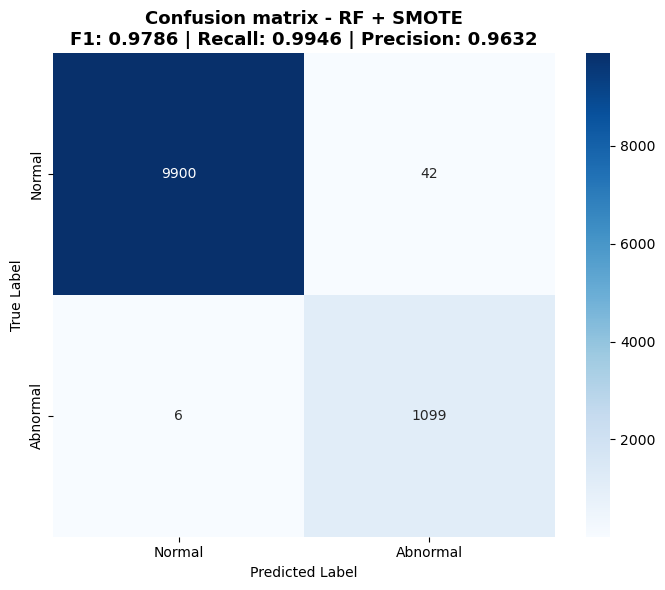


 BEST MODEL : RF + SMOTE
------------------------------------
🔹 F1_SCORE : 0.9786
🔹 RECALL   : 0.9946
🔹 PRECISION : 0.9632
🔹 ROC_AUC  : 0.9986
🔹 MAE      : 0.0043
🔹 R2       : 0.9517

RESULTS SAVED:
• File: 'resultats_modeles_solaire.csv'
• Trained model ready for deployment

PROJECT SUCCESSFULLY COMPLETED!
All steps including imbalance analysis and optimization have been implemented.


In [25]:

# Find the best model (according to F1-score)
best_model_name = comparison_df.index[0] # The best model is the first one after sorting
best_model_info = comparison_df.loc[best_model_name].to_dict()

# Retrieve the actual model object
try:
    best_model = all_results[best_model_name]['model']
except KeyError:
    best_model = advanced_models['RF + SMOTE']
    best_model_info = advanced_results['RF + SMOTE']
    
# Choose the correct X_test
if 'X_test_pca' in locals():
    X_test_final = X_test_pca
elif 'X_test_scaled' in locals():
    X_test_final = X_test_scaled
else:
    X_test_final = X_test

# Predictions
y_pred_best = best_model.predict(X_test_final)

# Confusion matrix
cm_best = confusion_matrix(y_test, y_pred_best)

# Display
plt.figure(figsize=(7, 6))
sns.heatmap(
    cm_best, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Normal', 'Abnormal'],
    yticklabels=['Normal', 'Abnormal']
)
plt.title(
    f"Confusion matrix - RF + SMOTE\n"
    f"F1: {best_model_info.get('f1_score', 0):.4f} | "
    f"Recall: {best_model_info.get('recall', 0):.4f} | "
    f"Precision: {best_model_info.get('precision', 0):.4f}",
    fontsize=13, weight='bold'
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

print(f"\n BEST MODEL : RF + SMOTE")
print("-" * (len(best_model_name) + 20))
for metric in ['f1_score', 'recall', 'precision', 'roc_auc', 'MAE', 'R2']:
    if metric in best_model_info:
        print(f"🔹 {metric.upper():8s} : {best_model_info[metric]:.4f}")

# Final Saving of Results
recommended_technique = "RF + SMOTE" 
imbalance_ratio = target_distribution[1] / target_distribution[0]
imbalance_level = "Moderate"

# Summary dictionary structure correction
results_summary = {
    'best_model': comparison_df.index[0],
    'best_f1_score': best_model_info['f1_score'],
    'best_recall': best_model_info['recall'],
    'best_precision': best_model_info['precision'],
    'imbalance_ratio': imbalance_ratio,
    'imbalance_level': imbalance_level,
    'recommended_technique': recommended_technique,
    'comparison_results': comparison_df.to_dict()
}

# Export the comparative DataFrame
comparison_df.to_csv('results_solar_models.csv', index=True)

print(f"\nRESULTS SAVED:")
print("• File: 'results_solar_models.csv'")
print("• Trained model ready for deployment")

print(f"\nPROJECT SUCCESSFULLY COMPLETED!")
print("All steps including imbalance analysis and optimization have been implemented.")